# Script to do the extraction face information

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

from deepface import DeepFace
from deepface.detectors import FaceDetector
from deepface.DeepFace import build_model
from deepface.commons.functions import load_image
from tensorflow import keras

from deepface.extendedmodels import Age, Gender, Race, Emotion

In [29]:
detections_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/face_detection_results_1_HQ.npy'
face_detections = np.load(detections_path, allow_pickle=True)
face_detections = face_detections[0]
face = face_detections['10686']['face_1']['facial_area']


In [30]:
image_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames/10686.jpg'
frame = io.imread(image_path)
#cv2.rectangle(image, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations
#cv2.rectangle(frame, (face[0], face[1]), (face[2],face[3]), (0,255,100), 3) 
#fig = plt.figure(figsize=(15,7.5)) 
#plt.imshow(frame)
#plt.show() 

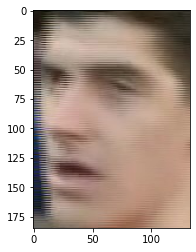

In [31]:
frame_face = frame[face[1]:face[3],face[0]:face[2],:]
plt.imshow(frame_face)
plt.show() 


## Model Code

In [32]:
# analyze output (emotions)
DeepFace.analyze(frame_face, actions = ['emotion'], enforce_detection=False)

{'emotion': {'angry': 53.253012895584106,
  'disgust': 8.497413439556567e-07,
  'fear': 0.33543643075972795,
  'happy': 0.0017288686649408191,
  'sad': 8.371694386005402,
  'surprise': 0.0006298650077951606,
  'neutral': 38.03749978542328},
 'dominant_emotion': 'angry',
 'region': {'x': 0, 'y': 0, 'w': 185, 'h': 133}}

In [33]:
from tensorflow.keras.preprocessing import image

def preprocess_face(img, target_size=(224, 224), grayscale = False, align = True):

    #img might be path, base64 or numpy array. Convert it to numpy whatever it is.
    img = load_image(img)
    base_img = img.copy()

    # img, region = detect_face(img = img, detector_backend = detector_backend, grayscale = grayscale, enforce_detection = enforce_detection, align = align)

    #--------------------------

    if img.shape[0] == 0 or img.shape[1] == 0:
        if enforce_detection == True:
            raise ValueError("Detected face shape is ", img.shape,". Consider to set enforce_detection argument to False.")
        else: #restore base image
            img = base_img.copy()

    #--------------------------

    #post-processing
    if grayscale == True:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #---------------------------------------------------
    #resize image to expected shape

    # img = cv2.resize(img, target_size) #resize causes transformation on base image, adding black pixels to resize will not deform the base image

    if img.shape[0] > 0 and img.shape[1] > 0:
        factor_0 = target_size[0] / img.shape[0]
        factor_1 = target_size[1] / img.shape[1]
        factor = min(factor_0, factor_1)

        dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
        img = cv2.resize(img, dsize)

        # Then pad the other side to the target size by adding black pixels
        diff_0 = target_size[0] - img.shape[0]
        diff_1 = target_size[1] - img.shape[1]
        if grayscale == False:
            # Put the base image in the middle of the padded image
            img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')
        else:
            img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2)), 'constant')

    #------------------------------------------

    #double check: if target image is not still the same size with target.
    if img.shape[0:2] != target_size:
        img = cv2.resize(img, target_size)

    #---------------------------------------------------

    #normalizing the image pixels

    img_pixels = image.img_to_array(img) #what this line doing? must?
    img_pixels = np.expand_dims(img_pixels, axis = 0)
    img_pixels /= 255 #normalize input in [0, 1]

    #---------------------------------------------------


    return img_pixels

In [34]:
# using our model directly using the library funcionts (layer 13 is the same than analyze output), 8 is the flatten vect
# we have to go deeper
model = build_model('Emotion')
img = preprocess_face(img = frame_face, target_size = (48, 48), grayscale = True)
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
features = extractor(img)
vector = features[8].numpy()[0]
#vector

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         1

## Genrator Code

In [36]:
from multiprocessing import Pool
from pathlib import Path

In [37]:
# we will only read the images that have a face
faces_frames = [k for k, v in face_detections.items() if len(v) > 0]


In [61]:
def load_image1(frame_idx, frame_path):
    # frame_idx, frame_path = arg
    img = cv2.imread(frame_path)
    return frame_idx, img

class FaceFeeder:

    def __init__(self, directory, valid_frames, batch_size, num_processes=10):

        self.directory = Path(directory)
        self.valid_frames = valid_frames
        self.batch_size = batch_size
        self.num_processes = num_processes

        batch_list = []
        for i in range(0, len(self.valid_frames), self.batch_size):
            batch_list.append(self.valid_frames[i:i + self.batch_size])
        self.batch_list = batch_list

    def __len__(self):
        return int(np.ceil(len(self.valid_frames) / self.batch_size))

    def __getitem__(self, index):

        batch = np.zeros([self.batch_size, 1024, 1820, 3])  # FIXME: revisar size mas videos
        # esta size es la que devuelve el preprocess
        im_infos = [None] * self.batch_size
        im_scales = [None] * self.batch_size

        # for idx, num in enumerate(self.batch_list[index]):
        #     frame_path = str(self.directory.joinpath(str(f'{num:05}') + '.jpg'))
        #     im_tensor, im_info, im_scale = load_image(frame_path)
        #
        #     # im = cv2.imread(str(self.directory.joinpath(str(f'{num:05}')+'.jpg')))
        #     # im_tensor, im_info, im_scale = preprocess.preprocess_image(im, True)
        #
        #     batch[idx, :, :, :] = im_tensor
        #     im_infos.append(im_info)
        #     im_scales.append(im_scale)

        frame_paths, frame_indices = [], []
        for idx, num in enumerate(self.batch_list[index]):
            # frame_paths.append(str(self.directory.joinpath(str(f'{num:05}') + '.jpg')))
            #TODO: keep in mind now num is a string
            frame_paths.append(str(self.directory.joinpath(str(f'{num}') + '.jpg')))
            frame_indices.append(idx)
        
        for path, index in zip(frame_paths, frame_indices):
            im_id, im = load_image1(index, str(path))
            print(path, index)
        '''with Pool(processes=self.num_processes) as pool:
            for idx, preprocessed_frame in pool.imap_unordered(load_image, zip(frame_indices, frame_paths)):
                im_tensor, im_info, im_scale = preprocessed_frame
                batch[idx, :, :, :] = im_tensor
                im_infos[idx] = im_info
                im_scales[idx] = im_scale'''

        #return batch, im_infos, im_scales

In [62]:
frames_dir = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames'
l = FaceFeeder(frames_dir, faces_frames, 2)

l.__getitem__(2)
l.batch_list[2]

../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames/01094.jpg 0
../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames/01095.jpg 1


['01094', '01095']

In [1]:
l

NameError: name 'l' is not defined